# SetFit Text Classification Hyperparameter Search

In this notebook, we'll learn how to do hyperparameter search with SetFit.

## Setup

If you're running this Notebook on Colab or some other cloud platform, you will need to install the `setfit` and `optuna` libraries. Uncomment the following cell and run it:

In [1]:
# %pip install setfit[optuna]

In [2]:
import numpy as np
from datasets import load_dataset
from sentence_transformers.losses import CosineSimilarityLoss
from setfit import SetFitModel, SetFitTrainer

First, we prepare the dataset. For details, see the multilabel training notebook.

In [3]:
def encode_labels(record):
    return {"labels": [record[feature] for feature in features]}


num_samples = 4
dataset = load_dataset("ethos", "multilabel")

features = dataset["train"].column_names
features.remove("text")
samples = np.concatenate([np.random.choice(np.where(dataset["train"][f])[0], num_samples) for f in features])
dataset = dataset.map(encode_labels)
train_dataset = dataset["train"].select(samples)
eval_dataset = dataset["train"].select(np.setdiff1d(np.arange(len(dataset["train"])), samples))

Reusing dataset ethos (/root/.cache/huggingface/datasets/ethos/multilabel/1.0.0/898d3d005459ee3ff80dbeec2f169c6b7ea13de31a08458193e27dec3dd9ae38)


  0%|          | 0/1 [00:00<?, ?it/s]

Parameter 'function'=<function encode_labels at 0x7f9bfbd45870> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/433 [00:00<?, ?ex/s]

## Hyperparameter search
For a hyperparameter search we need several changes to the normal training setup:

* Instead of a model, we pass a `model_init` function, which optionally can use the optuna trial
* We set up a function that defines which parameters we are interested in optimizing

In [4]:
model_id = "sentence-transformers/paraphrase-mpnet-base-v2"


def make_model(trial=None):
    multi_target_strategy = trial.params["multi_target_strategy"] if trial else "one-vs-rest"
    return SetFitModel.from_pretrained(
        model_id, multi_target_strategy=multi_target_strategy
    )

In [5]:
trainer = SetFitTrainer(
    model_init=make_model,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    loss_class=CosineSimilarityLoss,
    num_epochs=1,
    num_iterations=5,
    column_mapping={"text": "text", "labels": "label"},
)

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


For this particular trial, we try to find the optimal learning rate, `multi_target_strategy`, and batch size for training with only 5 iterations on 4 samples/class.

In [6]:
def hyperparameter_search_function(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-6, 1e-3, log=True),
        "batch_size": trial.suggest_categorical("batch_size", [4, 8, 16, 32]),
        "multi_target_strategy": trial.suggest_categorical("multi_target_strategy", ["one-vs-rest", "multi-output", "classifier-chain"])
    }

Now, we are ready to do the hyperparameter search. The default settings maximize accuracy, which is fine here. As we are searching 3 parameters, we choose a slightly higher number of trials than the default 10.

In [ ]:
best = trainer.hyperparameter_search(hyperparameter_search_function, n_trials=25)
best

We can study the optimization results in more detail using the `backend` value of the results.

/tmp/ipykernel_221101/1204669043.py:3: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(best.backend);


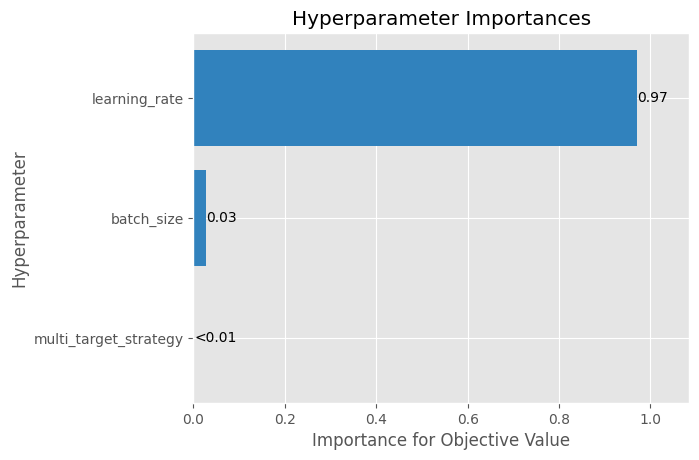

In [10]:
from optuna.visualization.matplotlib import plot_param_importances

plot_param_importances(best.backend);

The final step is to train using the optimal parameters and check the model's performance again using the `evaluate()` method. 

In [18]:
model = SetFitModel.from_pretrained(model_id, multi_target_strategy=best.hyperparameters["multi_target_strategy"])
trainer = SetFitTrainer(
    model=model,
    learning_rate=best.hyperparameters["learning_rate"],
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    loss_class=CosineSimilarityLoss,
    batch_size=best.hyperparameters["batch_size"],
    num_epochs=1,
    num_iterations=5,
    column_mapping={"text": "text", "labels": "label"},
)
trainer.train()

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset
***** Running training *****
  Num examples = 450
  Num epochs = 1
  Total optimization steps = 29
  Total train batch size = 16


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/29 [00:00<?, ?it/s]

In [19]:
metrics = trainer.evaluate()
best.objective, metrics

Applying column mapping to evaluation dataset
***** Running evaluation *****


(0.19451371571072318, {'accuracy': 0.20199501246882792})